## PyTorch自动求导和梯度下降原理

本文以华氏温度转换为摄氏温度（一元线性回归模型）为例子，讲解了深度学习框架（PyTorch）自动求导和梯度下降的原理。文章内容分为三节，层层递进，分别是：
1. 手动反向传播求导、手动梯度下降
2. 自动求导，手动梯度下降
3. 自动求导，自动梯度下降

In [1]:
%matplotlib inline
import torch
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
torch.set_printoptions(edgeitems=2)

In [2]:
torch.__version__

'1.3.1'

In [3]:
# 数据
Y = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # 摄氏度 Celsius
X = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # 华氏度 Fahrenheit

In [4]:
# 转化成张量
Y = torch.tensor(Y, requires_grad=False)
X = torch.tensor(X, requires_grad=False)
X, Y

(tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
         48.4000, 60.4000, 68.4000]),
 tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
          6.0000, 13.0000, 21.0000]))

模型与损失函数。这里使用最简单的一元线性回归模型和均方根损失函数

In [5]:
def model(X, w, b):
    return w * X + b

In [6]:
def loss_fn(Y_hat, Y):
    squared_diffs = (Y_hat - Y)**2
    return squared_diffs.mean()

### 手动反向传播求导、手动梯度下降

In [7]:
# 模型参数
w = torch.ones(1)
b = torch.zeros(1)

In [8]:
# 模型预测输出
Y_hat = model(X, w, b)
Y_hat

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [9]:
# 模型损失
loss = loss_fn(Y_hat, Y)
loss

tensor(1763.8846)

In [10]:
# 手动编写反向传播算法求解模型损失对模型参数的梯度
def dloss_fn(Y_hat, Y):
    dsq_diffs = 2 * (Y_hat - Y)
    return dsq_diffs

def dmodel_dw(X, w, b):
    return X

def dmodel_db(X, w, b):
    return 1.0

def grad_fn(X, Y, Y_hat, w, b):
    dloss_dw = dloss_fn(Y_hat, Y) * dmodel_dw(X, w, b)
    dloss_db = dloss_fn(Y_hat, Y) * dmodel_db(X, w, b)
    return torch.stack([dloss_dw.mean(), dloss_db.mean()])

In [11]:
def training_loop(n_epochs, learning_rate, params, X, Y, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        Y_hat = model(X, w, b)  # <1>
        loss = loss_fn(Y_hat, Y)
        grad = grad_fn(X, Y, Y_hat, w, b)  # <2>

        params = params - learning_rate * grad # 手动梯度下降

        if epoch % 30000 == 0:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [12]:
params = training_loop(
    n_epochs = 330000, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.00, 0.01]), 
    X = X, 
    Y = Y,
    print_params = False)

params

Epoch 30000, Loss 12.095908
Epoch 60000, Loss 6.133891
Epoch 90000, Loss 4.048903
Epoch 120000, Loss 3.319792
Epoch 150000, Loss 3.064586
Epoch 180000, Loss 2.975681
Epoch 210000, Loss 2.944574
Epoch 240000, Loss 2.933552
Epoch 270000, Loss 2.929731
Epoch 300000, Loss 2.928472
Epoch 330000, Loss 2.927906


tensor([  0.5358, -17.2503])

In [13]:
# 模型预测。根据训练后的参数进行模型预测。
Y_hat = model(X, *params)  

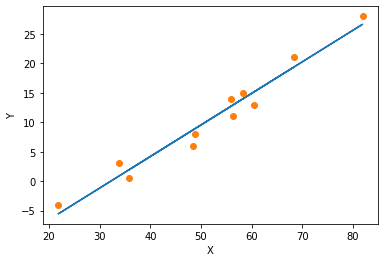

In [15]:
# 比较预测结果（直线）与标准答案（圆点）
fig = plt.figure()
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(X.numpy(), Y_hat.detach().numpy()) # <2>
plt.plot(X.numpy(), Y.numpy(), 'o')

### 自动求导，手动梯度下降

In [16]:
# 定义模型参数
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [17]:
# 模型参数目前没有梯度这个属性
params.grad is None

True

In [18]:
# 正向传播，求出模型预测和损失值
Y_hat = model(X, *params)
loss = loss_fn(Y_hat, Y)
Y_hat, loss

(tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
         48.4000, 60.4000, 68.4000], grad_fn=<AddBackward0>),
 tensor(1763.8846, grad_fn=<MeanBackward0>))

In [19]:
# 自动反向传播求导
loss.backward()

In [20]:
# 模型参数现在含有梯度这个属性，查看导数值
params.grad

tensor([4517.2969,   82.6000])

In [21]:
# 将导数值恢设置为零
if params.grad is not None:
    params.grad.zero_()
    
params.grad

tensor([0., 0.])

In [22]:
def training_loop(n_epochs, learning_rate, params, X, Y):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            params.grad.zero_()
        
        Y_hat = model(X, *params) 
        loss = loss_fn(Y_hat, Y)
        loss.backward()
        
        params = (params - learning_rate * params.grad).detach().requires_grad_()

        if epoch % 30000 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [23]:
training_loop(
    n_epochs = 330000, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.00, 0.01], requires_grad=True), # <1> 
    X = X, # <2> 
    Y = Y)

Epoch 30000, Loss 12.095908
Epoch 60000, Loss 6.133891
Epoch 90000, Loss 4.048903
Epoch 120000, Loss 3.319792
Epoch 150000, Loss 3.064586
Epoch 180000, Loss 2.975681
Epoch 210000, Loss 2.944574
Epoch 240000, Loss 2.933552
Epoch 270000, Loss 2.929731
Epoch 300000, Loss 2.928472
Epoch 330000, Loss 2.927906


tensor([  0.5358, -17.2503], requires_grad=True)

### 自动求导，自动梯度下降

In [25]:
# 定义模型参数
params = torch.tensor([1.00, 0.01], requires_grad=True)

In [26]:
# 定义模型优化器
optimizer = optim.SGD([params], lr=1e-4)

In [27]:
# 正向传播，求出模型预测和损失值
Y_hat = model(X, *params)
loss = loss_fn(Y_hat, Y)
Y_hat, loss

(tensor([35.7100, 55.9100, 58.2100, 81.9100, 56.3100, 48.9100, 33.9100, 21.8100,
         48.4100, 60.4100, 68.4100], grad_fn=<AddBackward0>),
 tensor(1764.7108, grad_fn=<MeanBackward0>))

In [28]:
# 自动反向传播求导
loss.backward()

In [29]:
params.grad

tensor([4518.3325,   82.6200])

In [30]:
# 自动梯度下降
optimizer.step()

In [31]:
# 更新后的参数值
params

tensor([0.5482, 0.0017], requires_grad=True)

In [32]:
def training_loop(n_epochs, optimizer, params, X, Y):
    for epoch in range(1, n_epochs + 1):
        Y_hat = model(X, *params) 
        loss = loss_fn(Y_hat, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 30000 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [33]:
params = torch.tensor([1.0, 0.01], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 330000, 
    optimizer = optimizer,
    params = params, # <1> 
    X = X,
    Y = Y)

Epoch 30000, Loss 12.095908
Epoch 60000, Loss 6.133891
Epoch 90000, Loss 4.048905
Epoch 120000, Loss 3.319792
Epoch 150000, Loss 3.064586
Epoch 180000, Loss 2.975681
Epoch 210000, Loss 2.944574
Epoch 240000, Loss 2.933552
Epoch 270000, Loss 2.929731
Epoch 300000, Loss 2.928472
Epoch 330000, Loss 2.927906


tensor([  0.5358, -17.2503], requires_grad=True)